In [307]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil # for copying files
import torchvision
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
%matplotlib inline

In [286]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [287]:
is_cuda = False
if torch.cuda.is_available():
   is_cuda = True

In [288]:
#path = '../cat-dog-classif/dogsandcats/' #testing a different path location
path = 'dogsandcats/train'

In [289]:
files = glob(os.path.join(path,'*/*.jpg'))

print (files[0])

dogsandcats/train\train\cat.0.jpg


In [290]:
# 25,000 cat and dog images inside train folder
print(f'Total no of images {len(files)}')


Total no of images 25000


In [291]:
# Why???????????????

no_of_images = 25000

print ("The total # of images has changed to: %s" % no_of_images)

The total # of images has changed to: 25000


In [292]:
no_of_images = len(files)

In [293]:
no_of_images*0.8

20000.0

In [294]:
# Shuffle using permutation
shuffle = np.random.permutation(no_of_images)

In [295]:
# Creates emtpy "valid" folder for validation dataset inside "dogsandcats" directory
os.mkdir(os.path.join(path,'valid'))

In [296]:
# Creates empty "dog" and "cat" subfolders within both "valid" and "train" directories
for t in ['train','valid']:
    for folder in ['dog/','cat/']:
        os.mkdir(os.path.join(path,t,folder))

In [297]:
print ("The path name is: %s" % path)

for i in shuffle[:2000]:
    #print (i)
    shutil.copy(files[i],'dogsandcats/train/valid/') # copies images into "valid" folder
    folder = os.path.basename(files[i].split('/')[-1].split('.')[0]) # had to use os.path.basename to extract only folder name
    #print ("The folder name is: %s" % folder) 
    image = os.path.basename(files[i].split('/')[-1]) # had to use os.path.basename to extract only image name
    #print ("The image name is: %s" % image) 
    
    os.rename(files[i],os.path.join(path,'valid',folder,image))

The path name is: dogsandcats/train


In [298]:
print ("The path name is: %s" % path)

for i in shuffle[2000:]:
    #print (i)
    shutil.copy(files[i],'dogsandcats/train/valid/')
    folder = os.path.basename(files[i].split('/')[-1].split('.')[0])
    #print ("The folder name is: %s" % folder) 
    image = os.path.basename(files[i].split('/')[-1])
    #print ("The image name is: %s" % image) 
    
    os.rename(files[i],os.path.join(path,'train',folder,image))

The path name is: dogsandcats/train


In [308]:
#if torch.cuda.is_available():
    #is_cuda = True
    
# Testing if CUDA is available or not
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [311]:
# Why say 256x256 if .resize is 224x224?
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
#simple_transform = transforms.Compose([transforms.Resize((32,32))
                                      #,transforms.ToTensor()
                                      # ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder('dogsandcats/train/train/',simple_transform)
valid = ImageFolder('dogsandcats/train/valid/',simple_transform)

print (train) # train folder has 23,000 unique images
print (valid) # valid has 2,000 unique seperated into dog & cat folder not found in train.

Dataset ImageFolder
    Number of datapoints: 23000
    Root Location: dogsandcats/train/train/
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 2000
    Root Location: dogsandcats/train/valid/
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None


In [312]:
# Train object holds all images and associated labels for the dataset

print(train.class_to_idx)
print(train.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


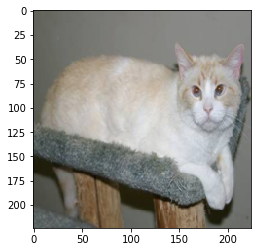

In [313]:
# Visualize data loaded into tensor
imshow(train[50][0])

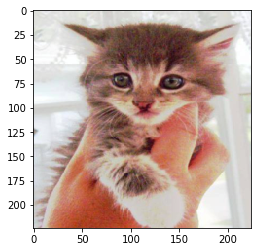

In [315]:
imshow(train[2][0])

In [316]:
# Convert "train" and "valid" datasets into dataloaders
trainloader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
validloader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [317]:
#dataset_sizes = {'train':len(trainloader.dataset),'valid':len(validloader.dataset)}

In [318]:
#dataloaders = {'train':trainloader,'valid':validloader}

In [319]:
# Defining the CNN from scratch
import torch.nn.functional as F

# pass nn.Module as parameter to subclass parent class (inheritance in python)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)
    
net = Net()
print (net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=56180, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)


In [343]:
model = Net()
if is_cuda:
    model.cuda()

In [344]:
# defining loss function and optimizer
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train the network over 2 iterations

#for epoch in range(2):  # loop over the dataset multiple times

    #running_loss = 0.0
    #for i, data in enumerate(trainloader, 0):
        # get the inputs
        #inputs, labels = data
       # print ("The input is: %s" % inputs)
        # print ("The label is: %s" % labels)

        # zero the parameter gradients
        #optimizer.zero_grad()

        # forward + backward + optimize
       # outputs = net(inputs)
        #loss = criterion(outputs, labels)
        # perform backward pass
       # loss.backward()
        # update the weights
       # optimizer.step()

        # print statistics
        #running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
       # print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))
        #running_loss = 0.0

#print('Finished Training')

In [ ]:
# to print out batch

#dataiter = iter(validloader)
#images, labels = dataiter.next()

# print images
#imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(8)))

In [353]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
        
    running_loss = 0.0
    running_correct = 0
    
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    #print (running_loss)
    #print (data_loader.dataset)
    loss = float(running_loss)/len(data_loader.dataset)
    accuracy = 100. * float(running_correct)/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)} which equals {accuracy:{10}.{4}}')
    return loss,accuracy

In [354]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

# changed from 1 to 5 epochs instead of 1 to 20 for debugging
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,trainloader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,validloader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.12 and training accuracy is 22088/23000 which equals      96.03
validation loss is  0.53 and validation accuracy is 1567/2000 which equals      78.35
training loss is  0.11 and training accuracy is 22114/23000 which equals      96.15
validation loss is  0.58 and validation accuracy is 1548/2000 which equals       77.4
training loss is   0.1 and training accuracy is 22181/23000 which equals      96.44
validation loss is  0.55 and validation accuracy is 1580/2000 which equals       79.0
training loss is 0.094 and training accuracy is 22253/23000 which equals      96.75
validation loss is  0.57 and validation accuracy is 1570/2000 which equals       78.5
training loss is 0.098 and training accuracy is 22199/23000 which equals      96.52
validation loss is  0.56 and validation accuracy is 1558/2000 which equals       77.9
training loss is 0.094 and training accuracy is 22232/23000 which equals      96.66
validation loss is  0.54 and validation accuracy is 1575/2000 whic

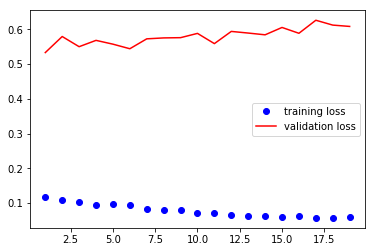

In [355]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

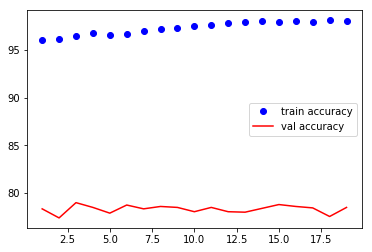

In [356]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()